In [2]:
from __future__ import division
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import cbpdn
from sporco.admm import ccmod
from sporco.dictlrn import dictlrn
from sporco import cnvrep
from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()

from pylab import *
import copy
from mlxtend.data import loadlocal_mnist
import platform
from scipy.io import loadmat
from keras.datasets import mnist


2023-12-01 15:25:28.872495: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:25:28.906745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:25:28.907659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 15:25:29.522682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# Load training and test images
(X, y), (test_X, test_y) = mnist.load_data()

# Reshape and normalise training and test images
train_ims = np.reshape(X,(60000,28,28))/255.
test_ims = np.reshape(test_X, (10000,28,28))/255.

In [7]:
# train_ims = np.reshape(X,(60000,28,28))/255.
D1_crop = np.load('dict_constants/d1_386500.npz')['d1']

dig_idx = [0, 1, 2, 3, 4, 5, 7, 13,15,17]
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})
b = cbpdn.ConvBPDN(D1_crop, train_ims[dig_idx,:,:], lmbda, opt, dimK=0)
X = b.solve()
print("ConvBPDN solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  7.65e+01  3.05e+01  9.19e+02  3.41e-01  1.96e+00  3.50e+00
   1  6.68e+01  1.61e+01  1.01e+03  1.96e-01  7.44e-01  3.50e+00
   2  7.03e+01  1.23e+01  1.16e+03  2.86e-01  4.81e-01  1.51e+00
   3  7.46e+01  9.85e+00  1.30e+03  2.92e-01  3.37e-01  9.78e-01
   4  7.31e+01  8.06e+00  1.30e+03  2.69e-01  2.43e-01  7.66e-01
   5  6.93e+01  7.40e+00  1.24e+03  2.30e-01  1.89e-01  6.77e-01
   6  6.30e+01  7.19e+00  1.12e+03  1.77e-01  1.55e-01  6.77e-01
   7  6.05e+01  7.05e+00  1.07e+03  1.52e-01  1.31e-01  6.09e-01
   8  5.80e+01  6.88e+00  1.02e+03  1.31e-01  1.12e-01  5.52e-01
   9  5.59e+01  6.74e+00  9.84e+02  1.13e-01  9.53e-02  5.01e-01
  10  5.26e+01  6.62e+00  9.21e+02  9.05e-02  8.28e-02  5.01e-01
  11  5.14e+01  6.54e+00  8.97e+02  8.19e-02  7.25e-02  4.40e-01
  12  5.01e+01  6.49e+00  8.73e+02  7.36e-02  6.26e-02  3.93e-01
  13  4.90e+01  6.43e+00 

In [4]:
import res_utils as ru

def encode_pix_rgb(im, Vt, Ht, Cv):
    N = Vt.shape[0]
    
    image_vec = 0.0 * ru.cvecl(N, 1)

    for m in range(im.shape[0]):
        for n in range(im.shape[1]):
            for c in range(im.shape[2]):
                P_vec = Cv[c] * (Vt ** m) * (Ht ** n)

                image_vec += P_vec * im[m, n, c]
            
    return image_vec
N = int(1e4)

# These are special base vectors for position that loop
Vt = ru.cvecl(N, 200)
Ht = ru.cvecl(N, 200)
Ct = ru.cvec(N,14)

def encode_pix(im, Vt, Ht):
    N = Vt.shape[0]
    
    image_vec = 0.0 * ru.cvecl(N, 1)

    for m in range(im.shape[0]):
        for n in range(im.shape[1]):
            P_vec = (Vt ** m) * (Ht ** n)

            image_vec += P_vec * im[m, n]
            
    return image_vec

im_vecs_pixel = np.zeros((10,N),dtype='complex')

for i,val in enumerate(dig_idx):
    im_vecs_pixel[i,:] = encode_pix(train_ims[val,:,:],Vt,Ht)

In [5]:
def encode_pix(im, Vt, Ht):
    N = Vt.shape[0]
    
    image_vec = 0.0 * ru.cvecl(N, 1)

    for m in range(im.shape[0]):
        for n in range(im.shape[1]):
            P_vec = (Vt ** m) * (Ht ** n)

            image_vec += P_vec * im[m, n]
            
    return image_vec

im_vecs_pixel = np.zeros((10,N),dtype='complex')

for i,val in enumerate(dig_idx):
    im_vecs_pixel[i,:] = encode_pix(train_ims[val,:,:],Vt,Ht)

In [6]:
def whiten(X,fudge=1e-9):
 
   # the matrix X should be observations-by-components
 
   # get the covariance matrix
    Xcov = np.dot(X.T,X)
 
   # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)
 
   # a fudge factor can be used so that eigenvectors associated with
   # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d+fudge))
    print(D)

   # whitening matrix
    W = np.dot(np.dot(V, D), V.T)
 
   # multiply by the whitening matrix
    X_white = np.dot(X, W)
 
    return X_white, W

In [7]:
im_vecs = np.zeros((10,N),dtype='complex')
for i in range(10):
    # print(X[i,:,:,0,:].shape)
    im_vecs[i,:] = encode_pix_rgb(X[i,:,:,0,:],Vt,Ht,Ct)

In [8]:
# cov_object = stats.Covariance.from_precision(precision)
x = np.reshape(train_ims[dig_idx,:,:],(10,784))
x -= np.mean(x,axis=0)
x_, _ = whiten(x.T)
x_ = x_.T
# matshow(x_ @ x_.T)
# print(x_)
# matshow(np.reshape(x_[1,:],(28,28)))
im_vecs_pixel_white = np.zeros((10,N),dtype='complex')

for i,val in enumerate(dig_idx):
    im_vecs_pixel_white[i,:] = encode_pix(np.reshape(x_[i,:],(28,28)),Vt,Ht)

[[3.16225559e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.12034289e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87119283e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.68054557e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.67024242e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.42468283e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

In [13]:
print(X.shape)
x2 = np.reshape(X,(10,28*28*8))
x2 -= np.mean(x2,axis=0)
x2_, _ = whiten(x2.T)
x2_ = x2_.T
print(x2_.shape)
matshow(x2_ @ x2_.T)
im_vecs_white = np.zeros((10,N),dtype='complex')

for i,val in enumerate(dig_idx):
    im_vecs_white[i,:] = encode_pix_rgb(np.reshape(x2_[i,:],(28,28,14)),Vt,Ht,Ct)

(10, 28, 28, 1, 8)
[[3.16225428e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93807382e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86040092e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72440507e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.63022235e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.56642357e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000

ValueError: cannot reshape array of size 6272 into shape (28,28,14)

Error in callback <function _draw_all_if_interactive at 0x1375ed550> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 480x480 with 1 Axes>

In [14]:
from scipy import stats
!pip install --upgrade scipy

In [15]:
# cov_object = stats.Covariance.from_precision(precision)
x = np.reshape(train_ims[dig_idx,:,:],(10,784))
x -= np.mean(x,axis=0)
x_, _ = whiten(x.T)
x_ = x_.T
matshow(x_ @ x_.T)
print(x_)
matshow(np.reshape(x_[1,:],(28,28)))

[[3.16225559e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.12034289e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87119283e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.68054557e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.67024242e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.42468283e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

Error in callback <function _draw_all_if_interactive at 0x1375ed550> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 480x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 480x480 with 1 Axes>

NameError: name 'svd_whiten' is not defined

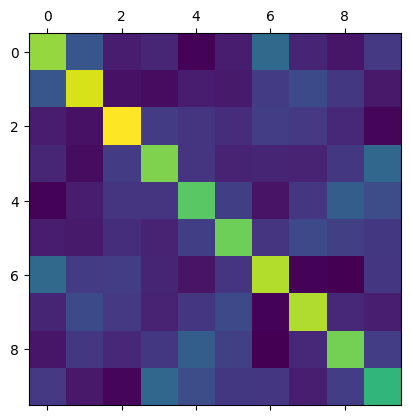

In [39]:
x = np.reshape(train_ims[dig_idx,:,:],(10,784))
x -= np.mean(x,axis=0)
xxt = x @ x.T
matshow(xxt)

xw = svd_whiten(x)
matshow(xw @ xw.T)

# pixel_white = svd_whiten(np.reshape(train_ims[dig_idx,:,:],(10,784)).T)
# matshow(np.reshape(pixel_white[:,0],(28,28)))
# matshow(train_ims[3,:,:])

In [17]:
def update_resonator_digit(codebooks,resonator,scene):
    resonator_update = np.ones((len(codebooks),v_size),dtype=complex)
    for i in range(len(codebooks)):
        new_code = scene
        for j in range(len(codebooks)):
            if i != j:
                new_code = new_code*(resonator[j,:]**-1)
        new_code = np.dot(codebooks[i].T,np.dot(np.conj(codebooks[i]),new_code.T))    
#         new_code = np.dot(outer_products[i],new_code.T)
        new_code = new_code / np.abs(new_code)
        resonator_update[i,:] = new_code
    return resonator_update

def update_resonator_digit_async(codebooks,resonator,scene):
    resonator_update = copy.copy(resonator)
    for i in range(len(codebooks)):
        new_code = scene
        for j in range(len(codebooks)):
            if i != j:
                new_code = new_code*(resonator_update[j,:]**-1)
        new_code = np.dot(codebooks[i].T,np.dot(np.conj(codebooks[i]),new_code.T))    
#         new_code = np.dot(outer_products[i],new_code.T)
        new_code = new_code / np.abs(new_code)
        resonator_update[i,:] = new_code
    return resonator_update

def g(x):
    return x / np.abs(x)

def gen_res_digit(resonator,codebooks,max_iters,tree):
    res_hist = []
    res_curr = resonator
    for i in range(max_iters):
        res_hist.append(copy.copy(res_curr))
        res_curr = update_resonator_digit_async(codebooks,res_curr,tree)
        if np.mean(np.cos(np.angle(np.ndarray.flatten(res_curr))-np.angle(np.ndarray.flatten(res_hist[-1])))) > 0.99:
            break
    res_hist.append(copy.copy(res_curr))
#         print i
    return i+1, res_hist

def dot_complex(vec1,vec2):
    num = np.dot(np.conj(vec1),vec2)
    denom = np.linalg.norm(vec1)*np.linalg.norm(vec2)
    return np.abs(num)/denom

In [41]:
space_dim = np.arange(20,301,20)
n_trials = 500
acc = np.zeros((space_dim.size,n_trials,2))
n_total = np.zeros((space_dim.size,n_trials,2))
print(space_dim)
for j in range(space_dim.size):

    V_code = np.zeros((space_dim[j],N),dtype='complex')
    H_code = np.zeros((space_dim[j],N),dtype='complex')
    for k in range(space_dim[j]):
        V_code[k,:] = Vt**k
        H_code[k,:] = Ht**k
        
    for k in range(n_trials):

        resonator = np.ones((3,N),dtype=complex)
        for i in range(3):
        #     resonator[i,:] = np.sum(codebooks[i],axis=0)
            resonator[i,:] = np.random.normal(0.0,1.0,size=(1,N)) + 1j*np.random.normal(0.0,1.0,size=(1,N))
            resonator[i,:] = resonator[i,:]/ np.abs(resonator[i,:])
        codebooks = [im_vecs,V_code,H_code]
        num_iters = 20
        
        im_seed = np.random.randint(10)
        x_shift = np.random.randint(space_dim[j])
        y_shift = np.random.randint(space_dim[j])

        n_iters, res_hist = gen_res_digit(resonator,codebooks,num_iters,im_vecs[im_seed,:]*Vt**y_shift*Ht**x_shift)

        progs = []
        for i in range(3):
            c = codebooks[i]
            corrs = np.zeros((n_iters,c.shape[0]),dtype=complex)
            for l in range(n_iters-1,n_iters):
                for m in range(c.shape[0]):
        #             print(k,i,j,codebooks[i].shape)
                    corrs[l,m] = dot_complex(res_hist[l][i,:],codebooks[i][m,:])
        #             corrs[k,j] = np.mean(np.cos(np.abs(np.angle(res_hist[k][i,:] - codebooks[i][j,:]))))
#                     print(corrs[l,m])
            progs.append(corrs)
#         print('.',im_seed,x_shift,y_shift)
#         print(np.argmax(progs[0][-1,:]),np.argmax(progs[1][-1,:]),np.argmax(progs[2][-1,:]))
        if np.argmax(progs[0][-1,:]) == im_seed and np.argmax(progs[1][-1,:]) == y_shift and np.argmax(progs[2][-1,:]) == x_shift:
            acc[j,k,0] = 1

            n_total[j,k,0] = n_iters
    print('sparse',space_dim[j],np.sum(acc[j,:,0]),np.sum(n_total[j,:,0]))

#     acc = 0
#     n_total = 0
    for k in range(n_trials):

        resonator = np.ones((3,N),dtype=complex)
        for i in range(3):
        #     resonator[i,:] = np.sum(codebooks[i],axis=0)
            resonator[i,:] = np.random.normal(0.0,1.0,size=(1,N)) + 1j*np.random.normal(0.0,1.0,size=(1,N))
            resonator[i,:] = resonator[i,:]/ np.abs(resonator[i,:])
        codebooks = [im_vecs_pixel,V_code,H_code]
        num_iters = 20
                
        im_seed = np.random.randint(10)
        x_shift = np.random.randint(space_dim[j])
        y_shift = np.random.randint(space_dim[j])
        
        n_iters, res_hist = gen_res_digit(resonator,codebooks,num_iters,im_vecs_pixel[im_seed,:]*Vt**y_shift*Ht**x_shift)

        progs = []
        for i in range(3):
            c = codebooks[i]
            corrs = np.zeros((n_iters,c.shape[0]),dtype=complex)
            for l in range(n_iters-1,n_iters):
                for m in range(c.shape[0]):
        #             print(k,i,j,codebooks[i].shape)
                    corrs[l,m] = dot_complex(res_hist[l][i,:],codebooks[i][m,:])
        #             corrs[k,j] = np.mean(np.cos(np.abs(np.angle(res_hist[k][i,:] - codebooks[i][j,:]))))
#                     print()
            progs.append(corrs)
        if np.argmax(progs[0][-1,:]) == im_seed and np.argmax(progs[1][-1,:]) == y_shift and np.argmax(progs[2][-1,:]) == x_shift:
            acc[j,k,1] = 1
            n_total[j,k,1] = n_iters
    print('pixel',space_dim[j],np.sum(acc[j,:,1]),np.sum(n_total[j,:,1]))


[ 20  40  60  80 100 120 140 160 180 200 220 240 260 280 300]
sparse 20 500.0 2085.0
pixel 20 367.0 1727.0
sparse 40 500.0 2172.0
pixel 40 359.0 1745.0
sparse 60 500.0 2252.0
pixel 60 332.0 1675.0
sparse 80 500.0 2316.0
pixel 80 338.0 1743.0
sparse 100 499.0 2392.0
pixel 100 360.0 1870.0
sparse 120 497.0 2419.0
pixel 120 310.0 1624.0
sparse 140 497.0 2486.0
pixel 140 325.0 1787.0
sparse 160 496.0 2607.0
pixel 160 313.0 1723.0
sparse 180 499.0 2724.0
pixel 180 306.0 1744.0
sparse 200 492.0 2744.0
pixel 200 307.0 1777.0
sparse 220 398.0 2377.0
pixel 220 250.0 1605.0
sparse 240 329.0 1996.0
pixel 240 191.0 1278.0
sparse 260 278.0 1723.0
pixel 260 143.0 1027.0
sparse 280 236.0 1448.0
pixel 280 133.0 927.0
sparse 300 208.0 1241.0
pixel 300 140.0 1013.0


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

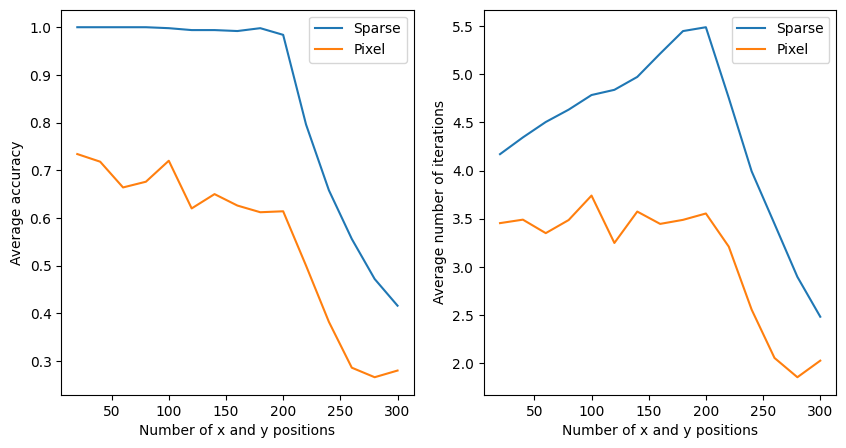

In [42]:
#plt.rcParams['text.usetex'] = False  # Disable LaTeX text rendering

fig,(ax1,ax2) = subplots(1,2,figsize=(10,5))
ax1.plot(space_dim,np.mean(acc[:,:,0],axis=1),label='Sparse')
ax1.plot(space_dim,np.mean(acc[:,:,1],axis=1),label='Pixel')
ax1.set_xlabel('Number of x and y positions')
ax1.set_ylabel('Average accuracy')
ax1.legend()
# figure(figsize=(5,5))
ax2.plot(space_dim,np.mean(n_total[:,:,0],axis=1),label='Sparse')
ax2.plot(space_dim,np.mean(n_total[:,:,1],axis=1),label='Pixel')
ax2.set_xlabel('Number of x and y positions')
ax2.set_ylabel('Average number of iterations')
ax2.legend()

In [ ]:
space_dim = np.arange(20,301,20)
n_trials = 500
acc = np.zeros((space_dim.size,n_trials,2))
n_total = np.zeros((space_dim.size,n_trials,2))
print(space_dim)
for j in range(space_dim.size):

    V_code = np.zeros((space_dim[j],N),dtype='complex')
    H_code = np.zeros((space_dim[j],N),dtype='complex')
    for k in range(space_dim[j]):
        V_code[k,:] = Vt**k
        H_code[k,:] = Ht**k
        
    for k in range(n_trials):

        resonator = np.ones((3,N),dtype=complex)
        for i in range(3):
        #     resonator[i,:] = np.sum(codebooks[i],axis=0)
            resonator[i,:] = np.random.normal(0.0,1.0,size=(1,N)) + 1j*np.random.normal(0.0,1.0,size=(1,N))
            resonator[i,:] = resonator[i,:]/ np.abs(resonator[i,:])
        codebooks = [im_vecs_white,V_code,H_code]
        num_iters = 20
        
        im_seed = np.random.randint(10)
        x_shift = np.random.randint(space_dim[j])
        y_shift = np.random.randint(space_dim[j])

        n_iters, res_hist = gen_res_digit(resonator,codebooks,num_iters,im_vecs_white[im_seed,:]*Vt**y_shift*Ht**x_shift)

        progs = []
        for i in range(3):
            c = codebooks[i]
            corrs = np.zeros((n_iters,c.shape[0]),dtype=complex)
            for l in range(n_iters-1,n_iters):
                for m in range(c.shape[0]):
        #             print(k,i,j,codebooks[i].shape)
                    corrs[l,m] = dot_complex(res_hist[l][i,:],codebooks[i][m,:])
        #             corrs[k,j] = np.mean(np.cos(np.abs(np.angle(res_hist[k][i,:] - codebooks[i][j,:]))))
#                     print(corrs[l,m])
            progs.append(corrs)
#         print('.',im_seed,x_shift,y_shift)
#         print(np.argmax(progs[0][-1,:]),np.argmax(progs[1][-1,:]),np.argmax(progs[2][-1,:]))
        if np.argmax(progs[0][-1,:]) == im_seed and np.argmax(progs[1][-1,:]) == y_shift and np.argmax(progs[2][-1,:]) == x_shift:
            acc[j,k,0] = 1

            n_total[j,k,0] = n_iters
    print('sparse',space_dim[j],np.sum(acc[j,:,0]),np.sum(n_total[j,:,0]))

#     acc = 0
#     n_total = 0
    for k in range(n_trials):

        resonator = np.ones((3,N),dtype=complex)
        for i in range(3):
        #     resonator[i,:] = np.sum(codebooks[i],axis=0)
            resonator[i,:] = np.random.normal(0.0,1.0,size=(1,N)) + 1j*np.random.normal(0.0,1.0,size=(1,N))
            resonator[i,:] = resonator[i,:]/ np.abs(resonator[i,:])
        codebooks = [im_vecs_pixel_white,V_code,H_code]
        num_iters = 20
                
        im_seed = np.random.randint(10)
        x_shift = np.random.randint(space_dim[j])
        y_shift = np.random.randint(space_dim[j])
        
        n_iters, res_hist = gen_res_digit(resonator,codebooks,num_iters,im_vecs_pixel_white[im_seed,:]*Vt**y_shift*Ht**x_shift)

        progs = []
        for i in range(3):
            c = codebooks[i]
            corrs = np.zeros((n_iters,c.shape[0]),dtype=complex)
            for l in range(n_iters-1,n_iters):
                for m in range(c.shape[0]):
        #             print(k,i,j,codebooks[i].shape)
                    corrs[l,m] = dot_complex(res_hist[l][i,:],codebooks[i][m,:])
        #             corrs[k,j] = np.mean(np.cos(np.abs(np.angle(res_hist[k][i,:] - codebooks[i][j,:]))))
#                     print()
            progs.append(corrs)
        if np.argmax(progs[0][-1,:]) == im_seed and np.argmax(progs[1][-1,:]) == y_shift and np.argmax(progs[2][-1,:]) == x_shift:
            acc[j,k,1] = 1
            n_total[j,k,1] = n_iters
    print('pixel',space_dim[j],np.sum(acc[j,:,1]),np.sum(n_total[j,:,1]))


[ 20  40  60  80 100 120 140 160 180 200 220 240 260 280 300]


/var/folders/2f/3wddnk1d66930qz4f367j7040000gn/T/ipykernel_16260/2365638375.py:23: RuntimeWarning: invalid value encountered in divide
  new_code = new_code / np.abs(new_code)


sparse 20 0.0 0.0
pixel 20 491.0 2591.0
sparse 40 0.0 0.0
pixel 40 494.0 2770.0
sparse 60 0.0 0.0
pixel 60 495.0 2893.0
sparse 80 0.0 0.0
pixel 80 493.0 2840.0
sparse 100 0.0 0.0
pixel 100 495.0 2860.0
sparse 120 0.0 0.0
pixel 120 490.0 2846.0


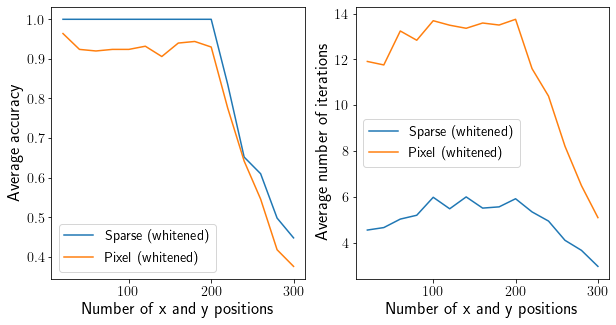

In [167]:
fig,(ax1,ax2) = subplots(1,2,figsize=(10,5))
ax1.plot(space_dim,np.mean(acc[:,:,0],axis=1),label='Sparse (whitened)')
ax1.plot(space_dim,np.mean(acc[:,:,1],axis=1),label='Pixel (whitened)')
ax1.set_xlabel('Number of x and y positions')
ax1.set_ylabel('Average accuracy')
ax1.legend()
# figure(figsize=(5,5))
ax2.plot(space_dim,np.mean(n_total[:,:,0],axis=1),label='Sparse (whitened)')
ax2.plot(space_dim,np.mean(n_total[:,:,1],axis=1),label='Pixel (whitened)')
ax2.set_xlabel('Number of x and y positions')
ax2.set_ylabel('Average number of iterations')
ax2.legend()


In [17]:
acc = 0
n_total = 0
for i in range(100):

    resonator = np.ones((3,N),dtype=complex)
    for i in range(3):
    #     resonator[i,:] = np.sum(codebooks[i],axis=0)
        resonator[i,:] = np.random.normal(0.0,1.0,size=(1,N)) + 1j*np.random.normal(0.0,1.0,size=(1,N))
        resonator[i,:] = resonator[i,:]/ np.abs(resonator[i,:])
    codebooks = [im_vecs_pixel,V_code,H_code]
    num_iters = 20
    n_iters, res_hist = gen_res_digit(resonator,codebooks,num_iters,im_vecs_pixel[0,:]*Vt**15*Ht**21)

    progs = []
    for i in range(3):
        c = codebooks[i]
        corrs = np.zeros((n_iters,c.shape[0]),dtype=complex)
        for k in range(n_iters):
            for j in range(c.shape[0]):
    #             print(k,i,j,codebooks[i].shape)
                corrs[k,j] = dot_complex(res_hist[k][i,:],codebooks[i][j,:])
    #             corrs[k,j] = np.mean(np.cos(np.abs(np.angle(res_hist[k][i,:] - codebooks[i][j,:]))))
            # print(k)
        progs.append(corrs)
    if np.argmax(progs[0][-1,:]) == 0 and np.argmax(progs[1][-1,:]) == 15 and np.argmax(progs[2][-1,:]) == 21:
        acc += 1
    n_total += n_iters
print(acc,n_total/100)

37 19.55
